In [1]:
n_epochs = 5
batch_size = 150
learning_rate = 0.01
l2_reg_coeff = 0.0005

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(4)
import tensorflow as tf; tf.set_random_seed(4)

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
y_train_cls = y_train.copy().astype(np.int64).reshape((-1,1))
y_test_cls = y_test.copy().astype(np.int64).reshape((-1,1))
y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32)

In [4]:
tf.reset_default_graph()

In [5]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [6]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg_coeff)
init_w = tf.contrib.layers.variance_scaling_initializer()
init_b = tf.keras.initializers.Zeros() 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [7]:
x = tf.placeholder(tf.float32, shape=[None, n_inputs])

w1 = tf.get_variable("w1", shape=[n_inputs, n_hidden1], dtype=tf.float32, initializer=init_w)
w2 = tf.get_variable("w2", shape=[n_hidden1, n_hidden2], dtype=tf.float32, initializer=init_w)
w3 = tf.transpose(w2, name="w3")  # tied weights
w4 = tf.transpose(w1, name="w4")  # tied weights

b1 = tf.get_variable("b1", shape=(n_hidden1,), dtype=tf.float32, initializer=init_b)
b2 = tf.get_variable("b2", shape=(n_hidden2,), dtype=tf.float32, initializer=init_b)
b3 = tf.get_variable("b3", shape=(n_hidden3,), dtype=tf.float32, initializer=init_b)
b4 = tf.get_variable("b4", shape=(n_outputs,), dtype=tf.float32, initializer=init_b)

hidden1 = activation(x @ w1 + b1)
hidden2 = activation(hidden1 @ w2 + b2)
hidden3 = activation(hidden2 @ w3 + b3)
outputs = hidden3 @ w4 + b4

In [8]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - x))
reg_loss = regularizer(w1) + regularizer(w2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [9]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx]

In [10]:
import sys
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for x_batch, _ in shuffle_batch(x_train, y_train_cls, batch_size):
            feed_dict = {x: x_batch}
            sess.run(training_op, feed_dict=feed_dict)
        loss_train = reconstruction_loss.eval(feed_dict=feed_dict)   
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
        saver.save(sess, "./my_model_all_layers.ckpt")                  

0 Train MSE: 0.015701713
1 Train MSE: 0.016620886
2 Train MSE: 0.016755551
3 Train MSE: 0.017496068
4 Train MSE: 0.017541606


In [11]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [12]:
def show_reconstructed_digits(model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        x_test_ = x_test[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={x: x_test_})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(x_test_[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


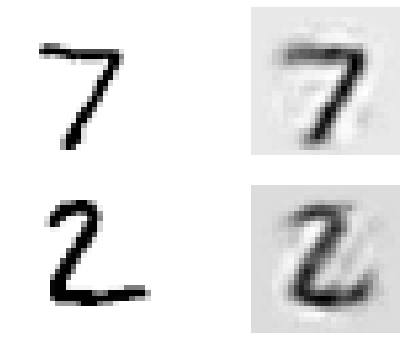

In [13]:
show_reconstructed_digits(model_path="./my_model_all_layers.ckpt")
#save_fig("reconstruction_plot")